In [1]:
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cdms2


CDMS regrider: regrid var1 (higher resolution) toward var2 (lower resolution)
Bilinear method works, but Conservative method created erroneous boundary around masked data.

In [2]:
file_name1 = '/Users/zhang40/Downloads/HadISST_CL-SST-ANN-global_test.nc'

In [3]:
fin = cdms2.open(file_name1)
var1 = fin('SST',squeeze=1)
print(var1.shape)

(720, 1440)


In [4]:
file_name2 = '/Users/zhang40/Downloads/HadISST_CL-SST-ANN-global_ref.nc'
fin2 = cdms2.open(file_name2)
var2 = fin2('SST',squeeze=1)
#print(var2.shape)
#print(var2.getLatitude().getBounds())
#print(dir(var2.getLatitude()))

In [5]:
var1_reg = var1.regrid(
            var2.getGrid(),
            regridTool='esmf',
            #regridMethod='bilinear',
            regridMethod='conservative',
        )

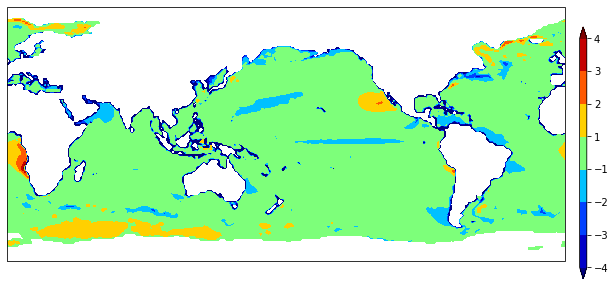

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
#ax.coastlines()
p1 = ax.contourf(
    var1_reg.getLongitude(),
    var1_reg.getLatitude(),
    var1_reg-var2,
    transform=ccrs.PlateCarree(),
    extend="both",
    cmap = 'jet',
    levels = [-4.0, -3, -2, -1, 1, 2, 3, 4]
)
 
cbax = fig.add_axes([0.92, 0.1, 0.01, 0.7])
cbar = fig.colorbar(p1, cax=cbax)
plt.show()

XARRAY regridding: regrid var1 (higher resolution) toward var2 (lower resolution)
Bilinear method works, but Conservative method fails with errors

In [7]:
import xarray as xr
import xesmf as xe
import netCDF4
import numpy

In [8]:
v1 = xr.open_dataset(file_name1).SST
#v1_lat_bnds = xr.open_dataset(file_name1).lat_bnds
#v1_lat_b = numpy.append(v1_lat_bnds[:,0],v1_lat_bnds[:,1][-1])
#v1_lon_bnds = xr.open_dataset(file_name1).lon_bnds
#v1_lon_b = numpy.append(v1_lon_bnds[:,0],v1_lon_bnds[:,1][-1])


In [9]:
v2 = xr.open_dataset(file_name2).SST
#print(v2)
#v2_lat_bnds = xr.open_dataset(file_name2).latitude_bnds
#v2_lat_b = numpy.append(v2_lat_bnds[:,0],v2_lat_bnds[:,1][-1])
#v2_lon_bnds = xr.open_dataset(file_name1).longitude_bnds
#v2_lon_b = numpy.append(v2_lon_bnds[:,0],v2_lon_bnds[:,1][-1])

Plot Test (bilinearly regridded) - Ref

In [10]:
regridder = xe.Regridder(v1, v2, 'bilinear')
#regridder = xe.Regridder(v1, v2, 'conservative_normed') #`conservative` method fails with errors:AttributeError: 'get_bounds' is not a valid attribute on the underlying xarray object.

#print(dir(xr.DataArray.from_cdms2(var1))) #Note, methods of cdms2 varialbes won't transfer 

/Users/zhang40/miniconda3/envs/e3sm_diags_dev_env_2.5.0/lib/python3.7/site-packages/xarray/core/dataarray.py:746: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [11]:
v1_reg = regridder(v1)

/Users/zhang40/miniconda3/envs/e3sm_diags_dev_env_2.5.0/lib/python3.7/site-packages/xesmf/frontend.py:476: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


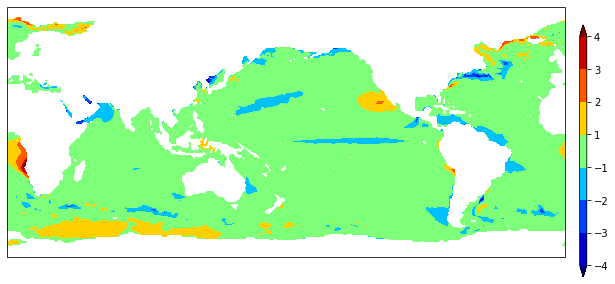

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
#ax.coastlines()
p1 = ax.contourf(
    v1_reg['longitude'],
    v1_reg['latitude'],
    v1_reg-var2,
    transform=ccrs.PlateCarree(),
    extend="both",
    cmap = 'jet',
    levels = [-4.0, -3, -2, -1, 1, 2, 3, 4]
)
 
cbax = fig.add_axes([0.92, 0.1, 0.01, 0.7])
cbar = fig.colorbar(p1, cax=cbax)
plt.show()

Plot Test (conservatively regridded) - Ref

In [13]:
test_grid_with_bounds = {'lon': v1['lon'],
                           'lat': v1['lat'],
                           'lon_b': numpy.linspace(-180, 180, 1441),
                           'lat_b': numpy.linspace(-90, 90, 721),
                          }

ref_grid_with_bounds = {'lon': v2['longitude'],
                           'lat': v2['latitude'],
                           'lon_b': numpy.linspace(0, 360, 361),
                           'lat_b': numpy.linspace(-90, 90, 181),
                          }



In [14]:
regridder_conserve = xe.Regridder(test_grid_with_bounds, ref_grid_with_bounds, method='conservative')

In [15]:
v1_reg_conserve = regridder_conserve(v1)

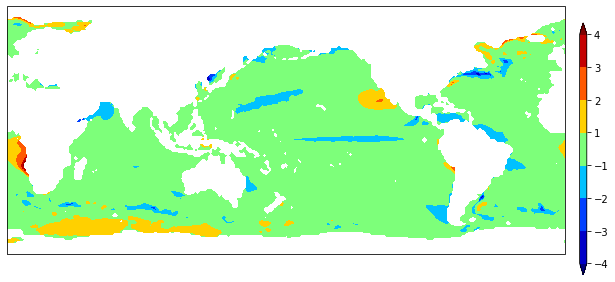

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
#ax.coastlines()
p1 = ax.contourf(
    v1_reg_conserve['longitude'],
    v1_reg_conserve['latitude'],
    v1_reg_conserve-var2,
    transform=ccrs.PlateCarree(),
    extend="both",
    cmap = 'jet',
    levels = [-4.0, -3, -2, -1, 1, 2, 3, 4]
)
 
cbax = fig.add_axes([0.92, 0.1, 0.01, 0.7])
cbar = fig.colorbar(p1, cax=cbax)
plt.show()

Quick way to plot a map

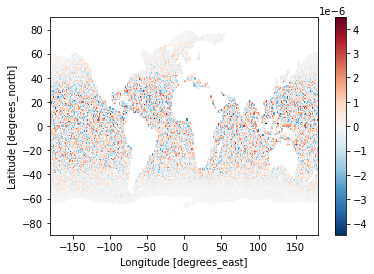

In [17]:
(v1_reg_conserve-var1_reg).plot()